# CORDIC core

This notebook visualizes various results obtained from the CORDIC core in [```rtl/cordic.v```](../rtl/cordic.v) using the [```tb/core_test.sv```](../tb/core_test.sv) testbench

---

In [5]:
import numpy as np
import matplotlib.pyplot as plt

---

## Helper functions

#### ```get_table_data(filename)``` 

Reads the log file with given filename and returns 5 numpy arrays :

| S.No  | Return array      | Array shape   | Description               |
|---    |:---:              |:---:          |---                        |
| 1     | ```idx_hist```    | ```size```    | Index                     |
| 2     | ```inp_hist```    | ```size, 3``` | Input variables           |
| 3     | ```exp_hist```    | ```size, 3``` | Expected output           |
| 4     | ```err_hist```    | ```size, 3``` | Actual - expected output  |
| 5     | ```sta_hist```    | ```size```    | True for OK, False for overflow |

#### ```separate(inp_list, sta_list)```

Separates or filters ```inp_list``` based on ```sta_list``` and returns 2 arrays

- ```good_list``` : ```inp_list``` items with 1 in ```sta_list``` at same index
- ```fail_list``` : ```inp_list``` items with 0 in ```sta_list``` at same index

#### ```vis_rot_inputs(inp_good, inp_fail, exp_good, exp_fail)```

Visualizes inputs for rotation mode. 3 plots are made

- Input x coordinate and y coordinate
- Expected x coordinate and y coordinate
- Input rotation angle and magnitude

In [6]:
class log_file:
    
    def __init__(self, inp):
        self.filename = inp
    
    def parse(self):
        with open(self.filename, "r") as f:
            # Line 1 parsing
            inp = f.readline().split(' ')
            if(len(inp) != 3):
                return False, "Line 1 must be in format <rotationSystem> <controlMode> test"
            
            if(inp[0] == "Hyperbolic"):
                self.hyp  = True
                self.circ = False
            elif(inp[0] == "Circular"):
                self.hyp  = False
                self.cic  = True
            else:
                return False, "Line 1 : rotationSystem '%s' not recognized"%(inp[0])
            
            if(inp[1] == "rotation"):
                self.rot  = True
                self.vec  = False
            elif(inp[1] == "vectoring"):
                self.rot  = False
                self.vec  = True
            else:
                return False, "Line 1 : controlMode '%s' not recognized"%(inp[1])

            # Skip Line 2
            f.readline()

            # Line 3
            inp = f.readline().split(':')
            if(len(inp) != 2 or inp[0].strip() != "Number of tests"):
                return False, "Line 3 must be Number of tests"
            self.num_tests = int(inp[1])

            # Line 4
            inp = f.readline().split(':')
            if(len(inp) != 2 or inp[0].strip() != "Number of CORDIC iterations"):
                return False, "Line 4 must be Number of CORDIC iterations"
            self.num_iter = int(inp[1])

            # Line 5
            inp = f.readline().split(':')
            if(len(inp) != 2 or inp[0].strip() != "Number format"):
                return False, "Line 5 must be Number format"
            if(len(inp[1].split('.')) != 2 or inp[1].strip()[0] != 'q'):
                return False, "Line 5 : '%s' : unidentified format. use qn.m format"%(inp[1])
            self.int_bits  = int(inp[1].split('.')[0].strip()[1:])
            self.frac_bits = int(inp[1].split('.')[1])

            # Line 6
            inp = f.readline().split(':')
            if(len(inp) != 2 or inp[0].strip() != "CORDIC iteration logging"):
                return False, "Line 6 must be CORDIC iteration logging"
            self.log_iter = True if inp[1].strip() == "ON" else False

            # Line 7
            inp = f.readline().split(':')
            if(len(inp) != 2 or inp[0].strip() != "Test logging"):
                return False, "Line 7 must be Test logging"
            self.log_tests = True if inp[1].strip() == "ON" else False

            # Find test table
            self.table_found = False
            inp = f.readline().strip()
            while(inp != "Test table"):
                inp = f.readline().strip()

            if(inp == "Test table"):
                table_found = True
            else:
                return
            
            f.readline()

            self.idx_hist = []
            self.inp_hist = []
            self.exp_hist = []
            self.err_hist = []
            self.sta_hist = []

            for i in range(self.num_tests):
                inp = f.readline().strip().split(':')
                if(inp[0][0] == '-'):
                    break

                if(len(inp) != 3):
                    print("ERR")

                dat = inp[1].split('|')

                if(len(dat) != 3):
                    print("ERR")

                self.idx_hist.append(int(inp[0]))
                self.inp_hist.append(tuple(map(float, dat[0].split(','))))
                self.exp_hist.append(tuple(map(float, dat[1].split(','))))
                self.err_hist.append(tuple(map(float, dat[2].split(','))))
                self.sta_hist.append(True if inp[2].strip() == "OK" else False)

    def separate(self, inp_list, sta_list):
        good_list   = np.asarray([inp_list[i] for i in range(len(inp_list)) if sta_list[i]])
        fail_list   = np.asarray([inp_list[i] for i in range(len(inp_list)) if not sta_list[i]])
        return good_list, fail_list

    def vis_rot_inputs(self):
        inp_good, inp_fail = self.separate(self.inp_hist, self.sta_hist)
        exp_good, exp_fail = self.separate(self.exp_hist, self.sta_hist)

        plt.figure(figsize=(30, 10), dpi=80)

        # Scatter plot for input coordintates
        plt.subplot(131)
        plt.scatter(inp_good[:, 0], inp_good[:, 1], s=5,  marker="o", c="green", label="Success")
        plt.scatter(inp_fail[:, 0], inp_fail[:, 1], s=10, marker="x", c="red",   label="Overflow")

        plt.xlabel("Input x coordinate")
        plt.ylabel("Input y coordinate")
        plt.title("Input coordinates")
        plt.legend()

        # Scatter plot for expected coordinates
        plt.subplot(132)
        plt.scatter(exp_good[:, 0], exp_good[:, 1], s=5,  marker="o", c="green", label="Success")
        plt.scatter(exp_fail[:, 0], exp_fail[:, 1], s=10, marker="x", c="red",   label="Overflow")

        plt.xlabel("Expected x coordinate")
        plt.ylabel("Expected y coordinate")
        plt.title("Expected output coordinates")
        plt.legend()

        # Scatter plot for input coordinate magnitude and input rotation angle
        plt.subplot(133)
        plt.scatter(inp_good[:, 2], np.linalg.norm(inp_good[:, 0:2], axis=1), s=5,  marker="o", c="green", label="Success")
        plt.scatter(inp_fail[:, 2], np.linalg.norm(inp_fail[:, 0:2], axis=1), s=10, marker="x", c="red",   label="Overflow")

        plt.xlabel("Input angle")
        plt.ylabel("Input coordinate magnitude")
        plt.title("Input rotation angle and input coordinate magnitude")
        plt.legend()

        plt.show()

    def vis_rot_error(self):
        inp_ls, _ = self.separate(self.inp_hist, self.sta_hist)
        exp_ls, _ = self.separate(self.exp_hist, self.sta_hist)
        err_ls, _ = self.separate(self.err_hist, self.sta_hist)
        
        x_err_dB   = 20 * np.log10(np.abs(err_ls[:, 0] / exp_ls[:, 0]))
        y_err_dB   = 20 * np.log10(np.abs(err_ls[:, 1] / exp_ls[:, 1]))
        ang_err_dB = 20 * np.log10(np.maximum(1e-10, np.abs(err_ls[:, 2])) / 180)
        mag_err_dB = 20 * np.log10(np.linalg.norm(err_ls[:, 0:2], axis=1) / np.linalg.norm(exp_ls[:, 0:2], axis=1))

        plt.figure(figsize=(30, 10), dpi=80)
        
        # Input angle v/s magnitude error
        plt.subplot(131)
        plt.scatter(inp_ls[:, 2], ang_err_dB, s=5)
        plt.ylim((-250, 0))
        plt.xlabel("Input angle (degrees)")
        plt.ylabel("Angle residual (dB)")
        plt.title("Input angle v/s angle residual")
            
        # Input angle v/s angle residual
        plt.subplot(132)
        plt.scatter(x_err_dB, y_err_dB, s=5)
        plt.axis('square')
        plt.xlabel("x error (dB)")
        plt.ylabel("y error (dB)")
        plt.title("X error v/s y error")

        plt.subplot(133)
        plt.hist(mag_err_dB, density = True, bins=30, histtype='step', label="Magnitude error")
        plt.hist(ang_err_dB, density = True, bins=30, histtype='step', label="Angle error")
        plt.xlim((-250, 0))
        plt.xlabel("Error (dB)")
        plt.ylabel("Density")
        plt.legend()
        plt.title("Error histogram")

        plt.show()

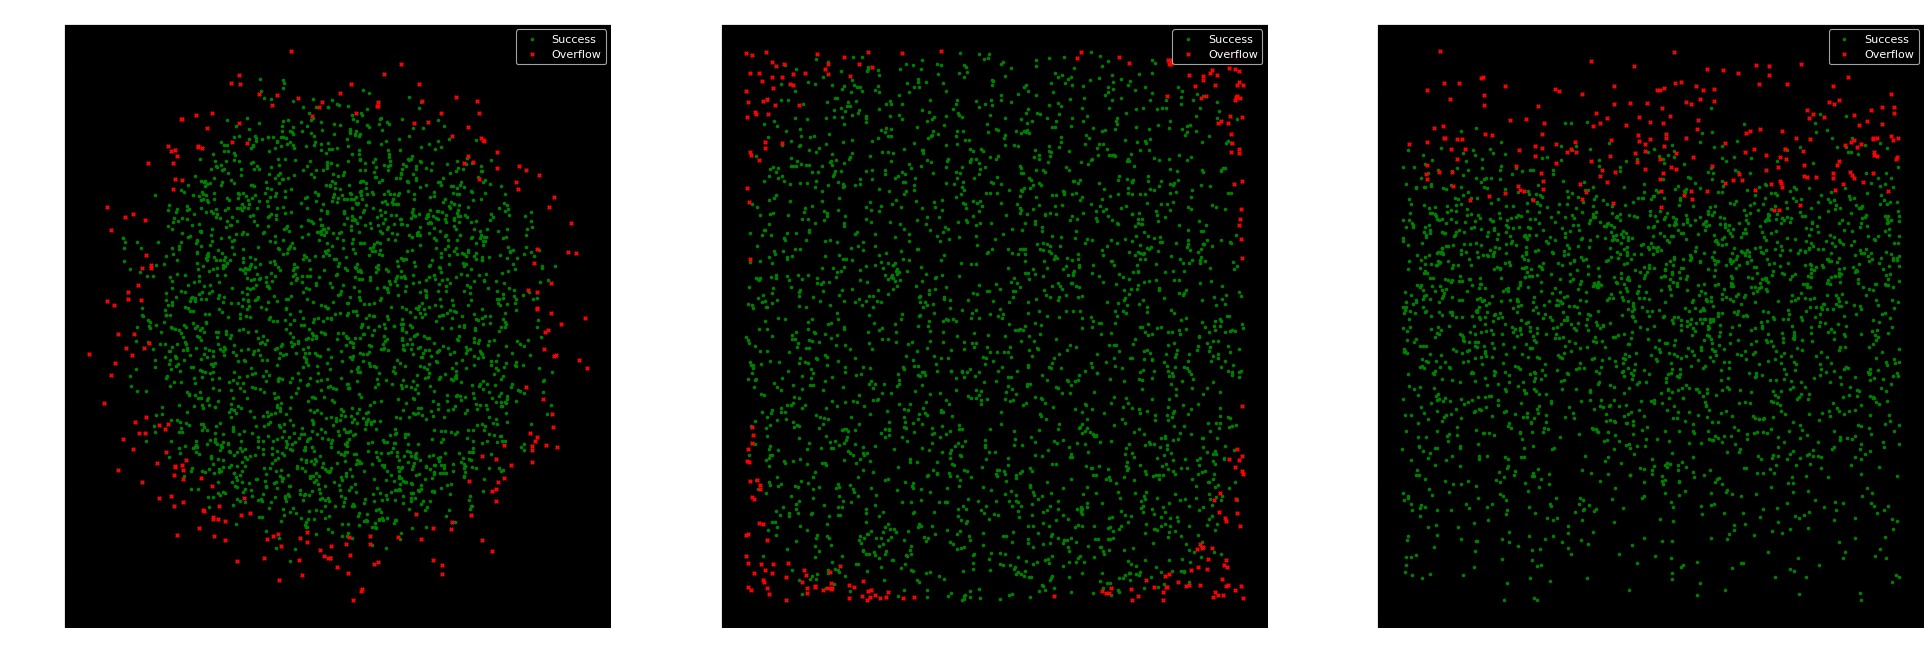

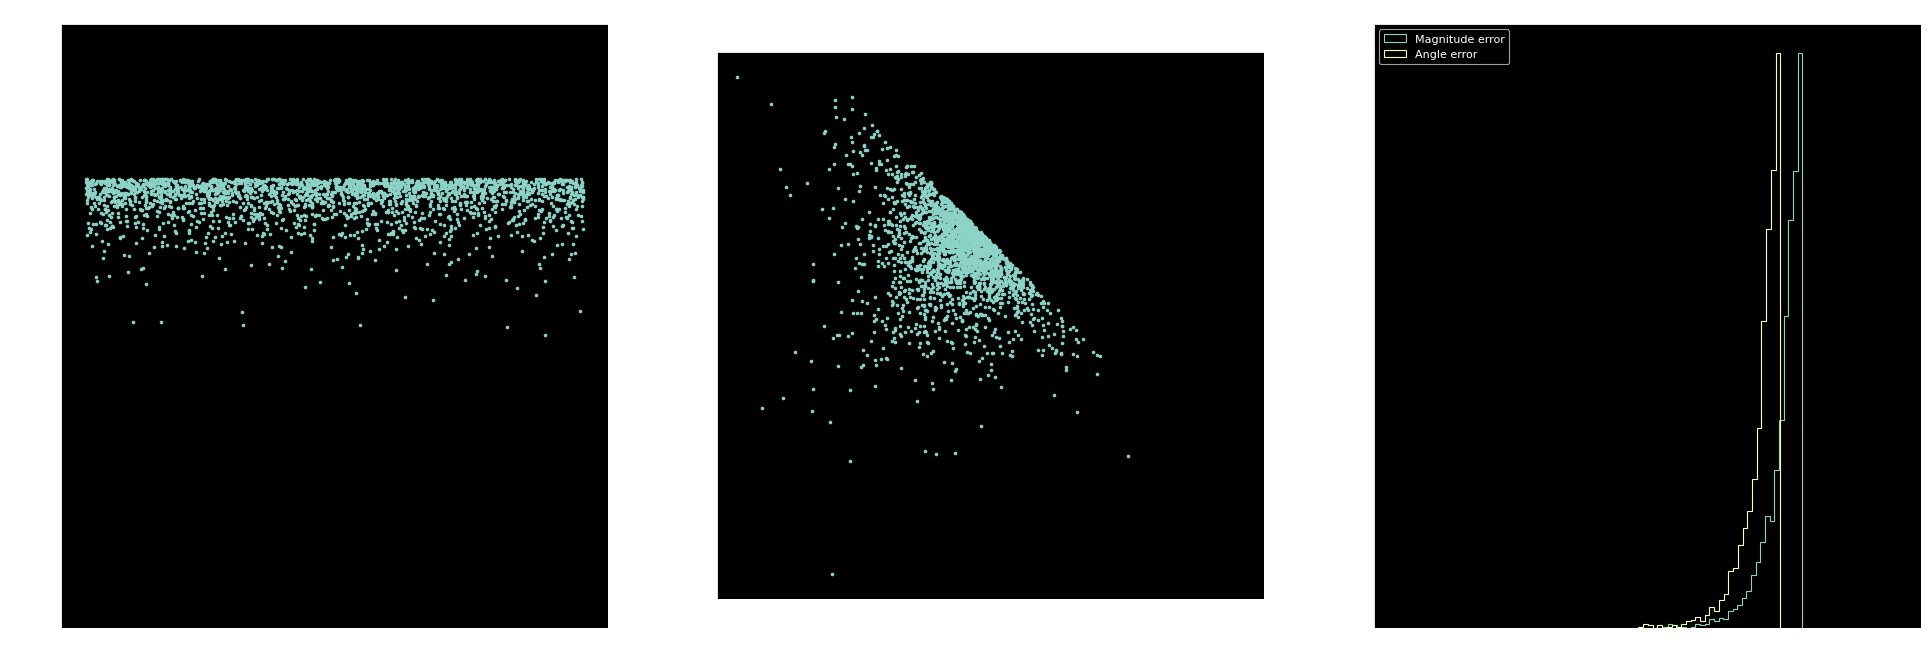

31


In [9]:
f1 = log_file("data/circ_rot/cr_10_off_off_x2500.txt")
f1.parse()
f1.vis_rot_inputs()
f1.vis_rot_error()
print(f1.frac_bits)

In [10]:
def vis_rot_inputs_file(filename):
    f1 = log_file(filename)
    f1.parse()
    f1.vis_rot_inputs()

def vis_rot_error_file(filename):
    f1 = log_file(filename)
    f1.parse()
    f1.vis_rot_error()

def vis_rotation_file(filename):
    f1 = log_file(filename)
    f1.parse()
    f1.vis_rot_inputs()
    f1.vis_rot_error()

---

# Rotation mode inputs

Look at the following plots to analyze coverage and overflow cases for rotation mode

Circular mode


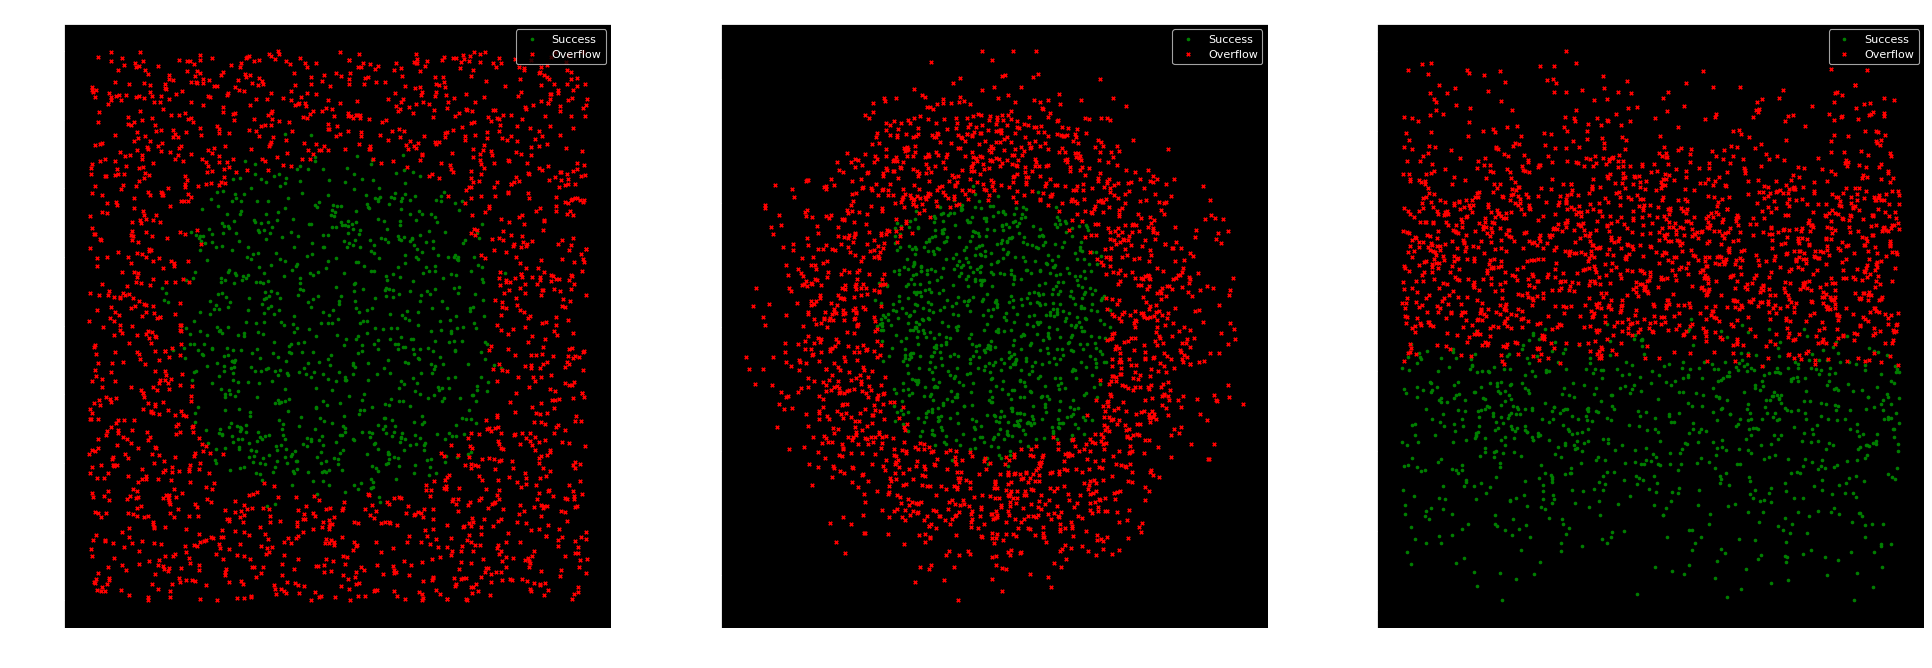

Hyperbolic mode


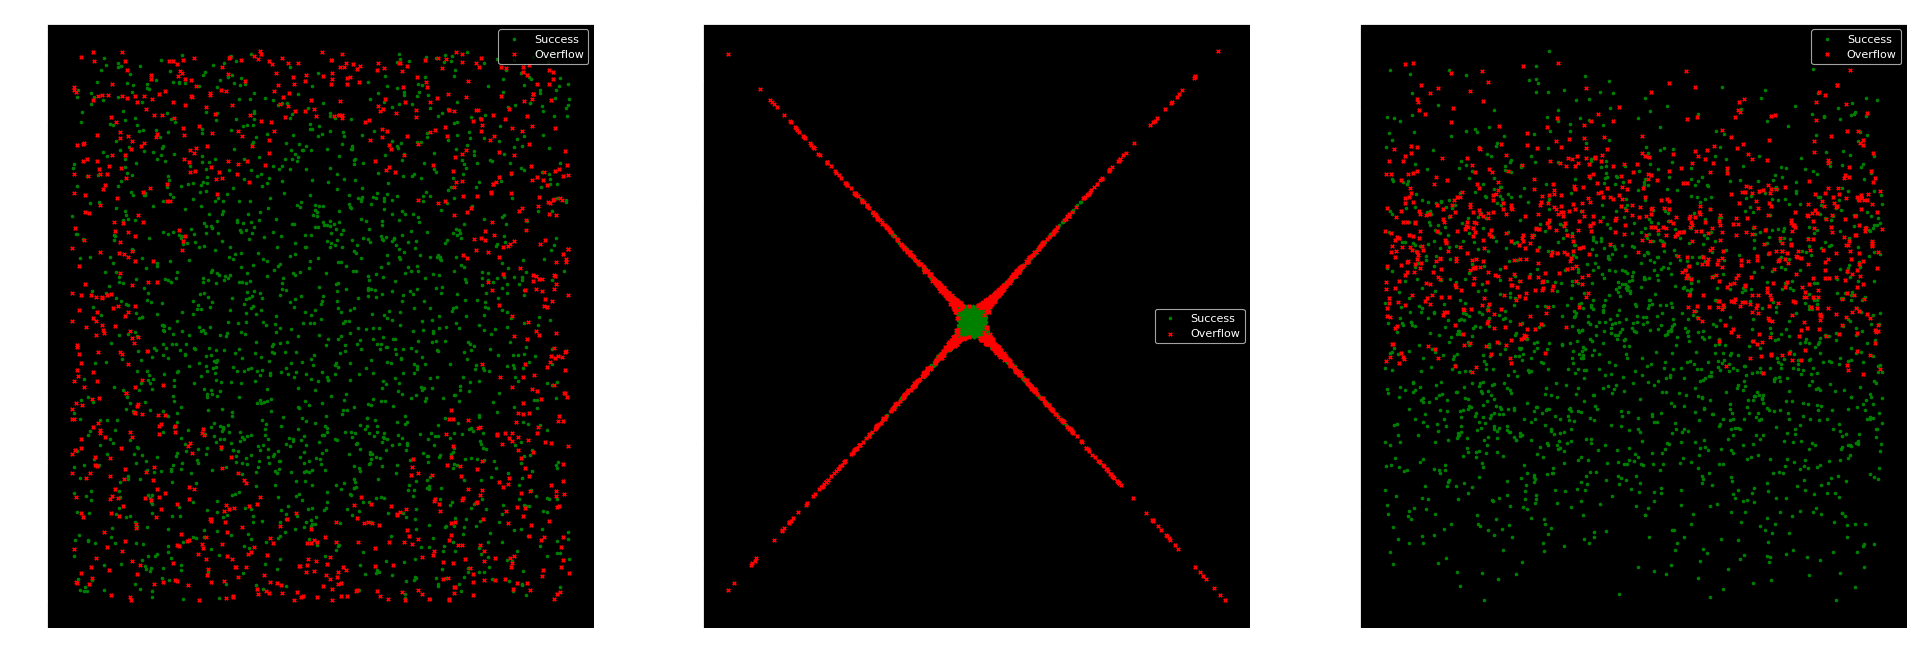

In [11]:
# View inputs for full (including inputs that will lead to out of bounds outputs)
print("Circular mode")
vis_rot_inputs_file("data/circ_rot/cr_30_off_off_x2500_full.txt")

print("Hyperbolic mode")
vis_rot_inputs_file("data/hyp_rot/hr_30_off_off_x2500_full.txt")

Circular mode


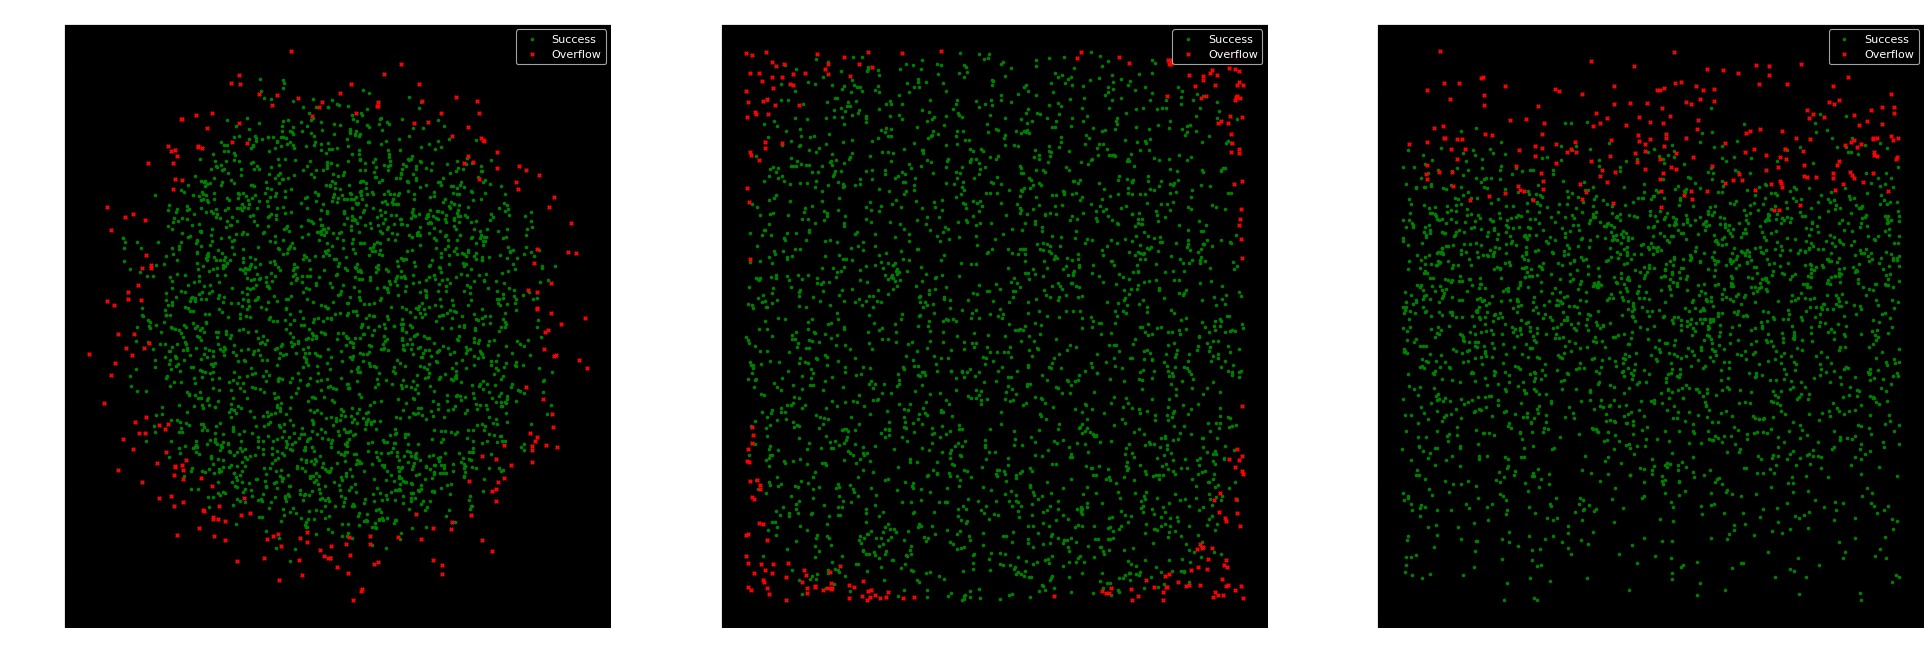

Hyperbolic mode


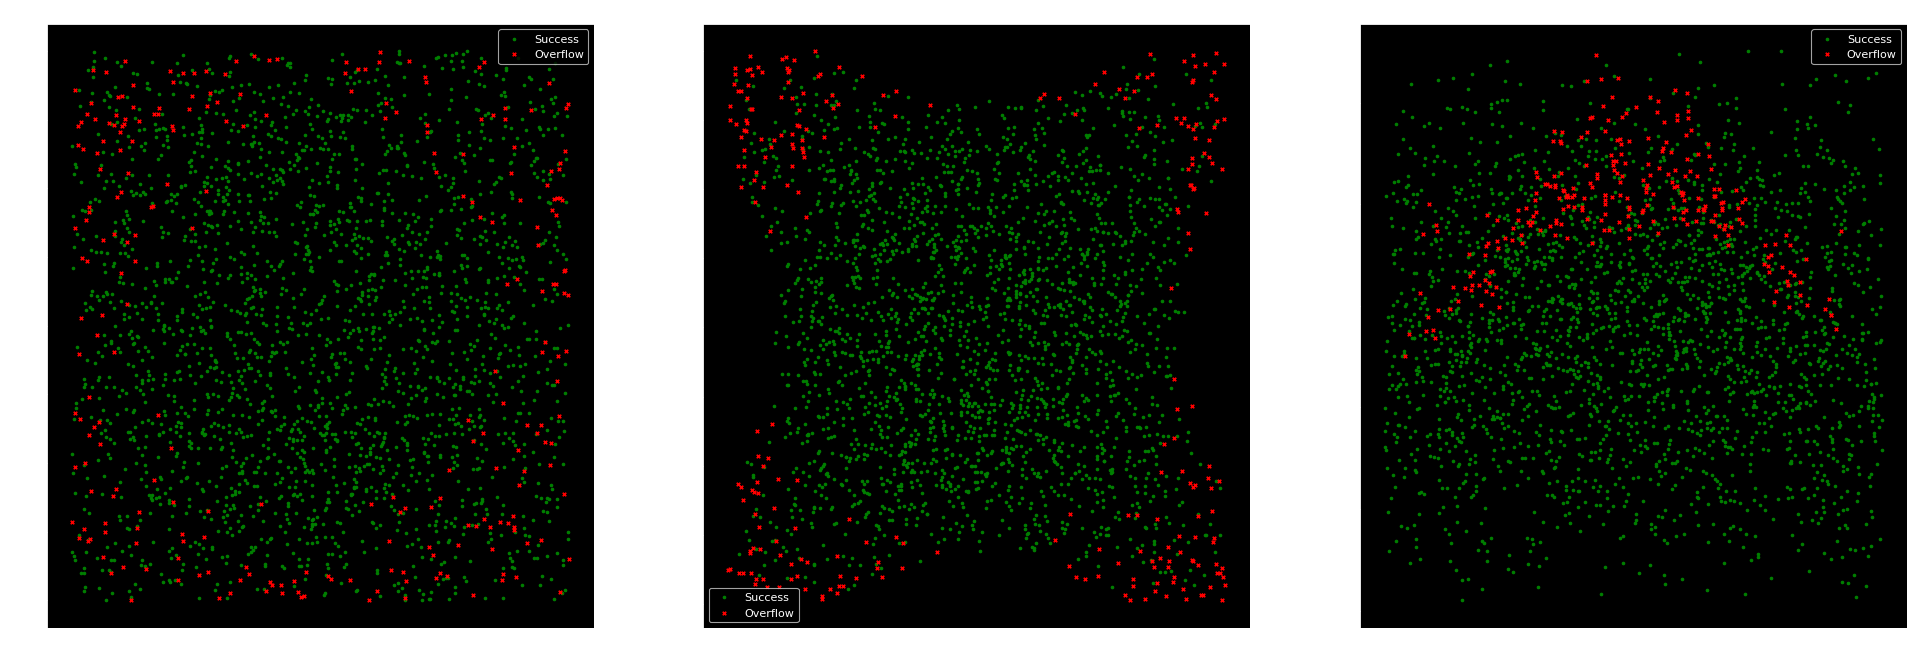

In [12]:
# View inputs without including those that will lead to out-of-bounds
print("Circular mode")
vis_rot_inputs_file("data/circ_rot/cr_30_off_off_x2500.txt")

print("Hyperbolic mode")
vis_rot_inputs_file("data/hyp_rot/hr_30_off_off_x2500.txt")

---

## Circular mode error analysis

Look at the following to see patterns in error for circular rotation mode for different number of CORDIC iterations and also compare the error plot when we do not apply the given constraints on angle, input values, etc

10 CORDIC iterations


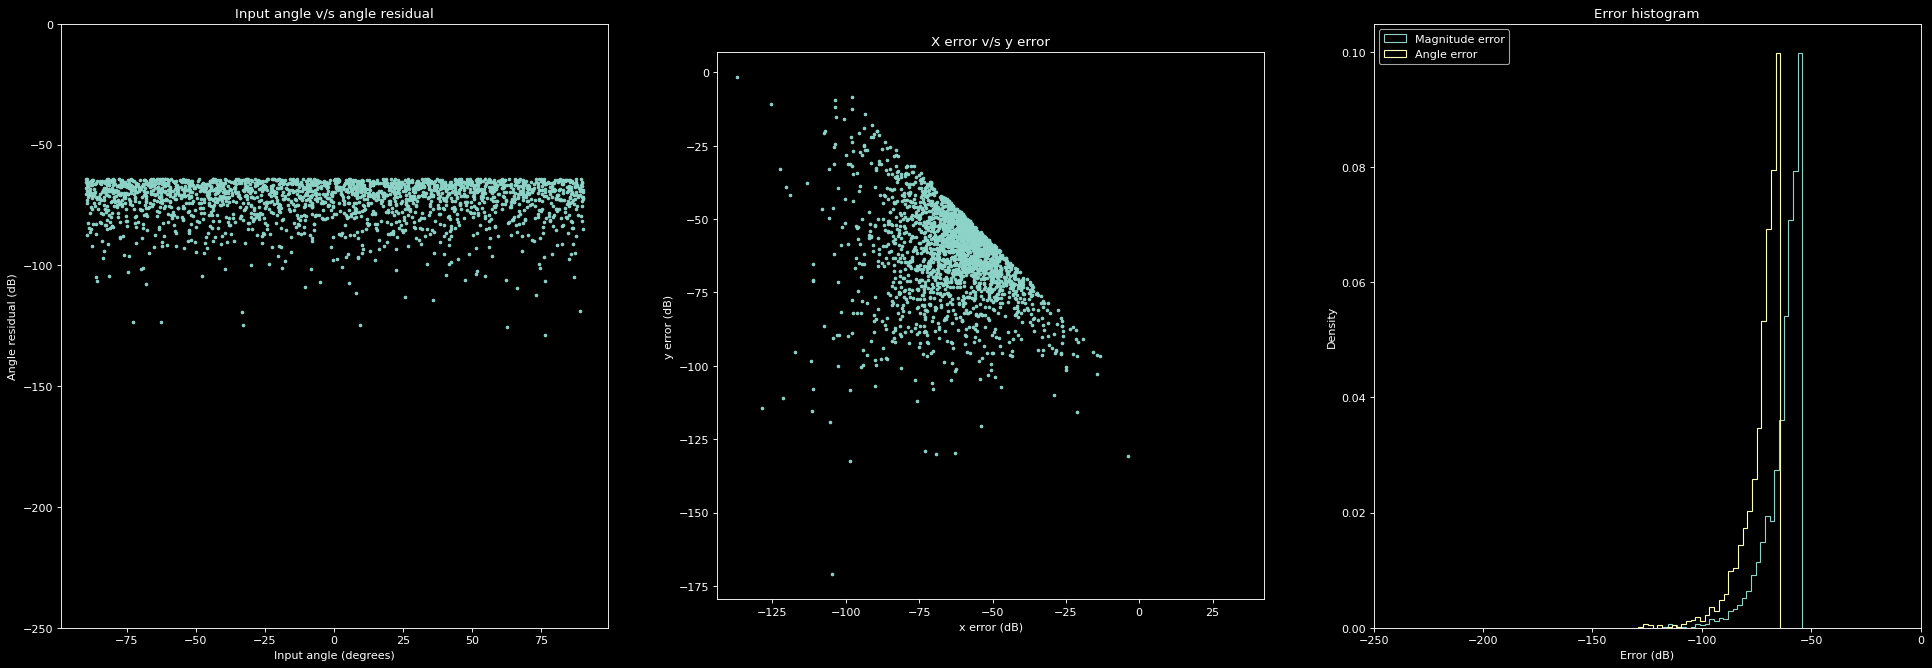

15 CORDIC iterations


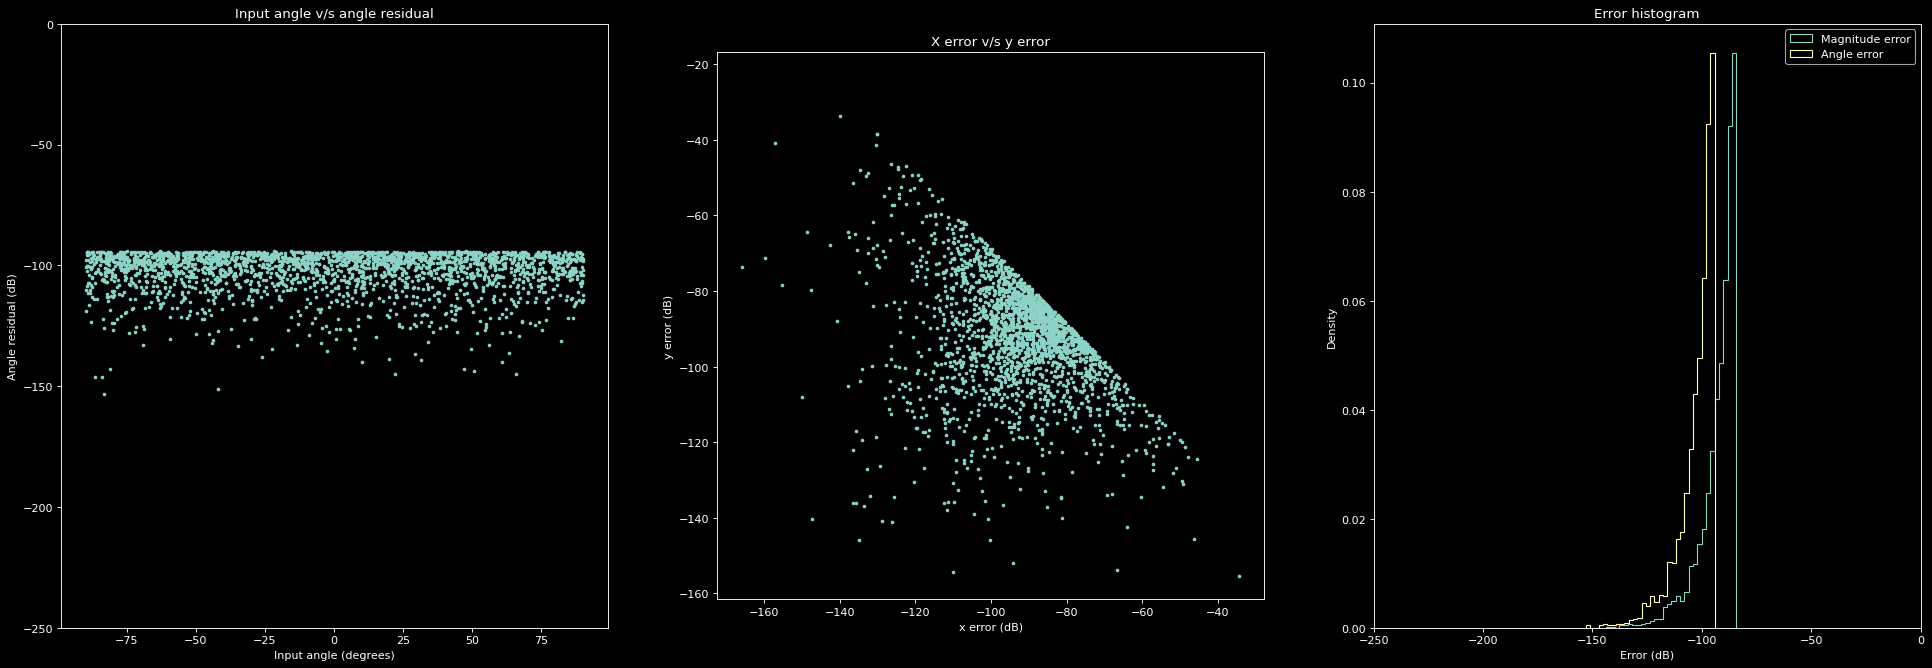

20 CORDIC iterations


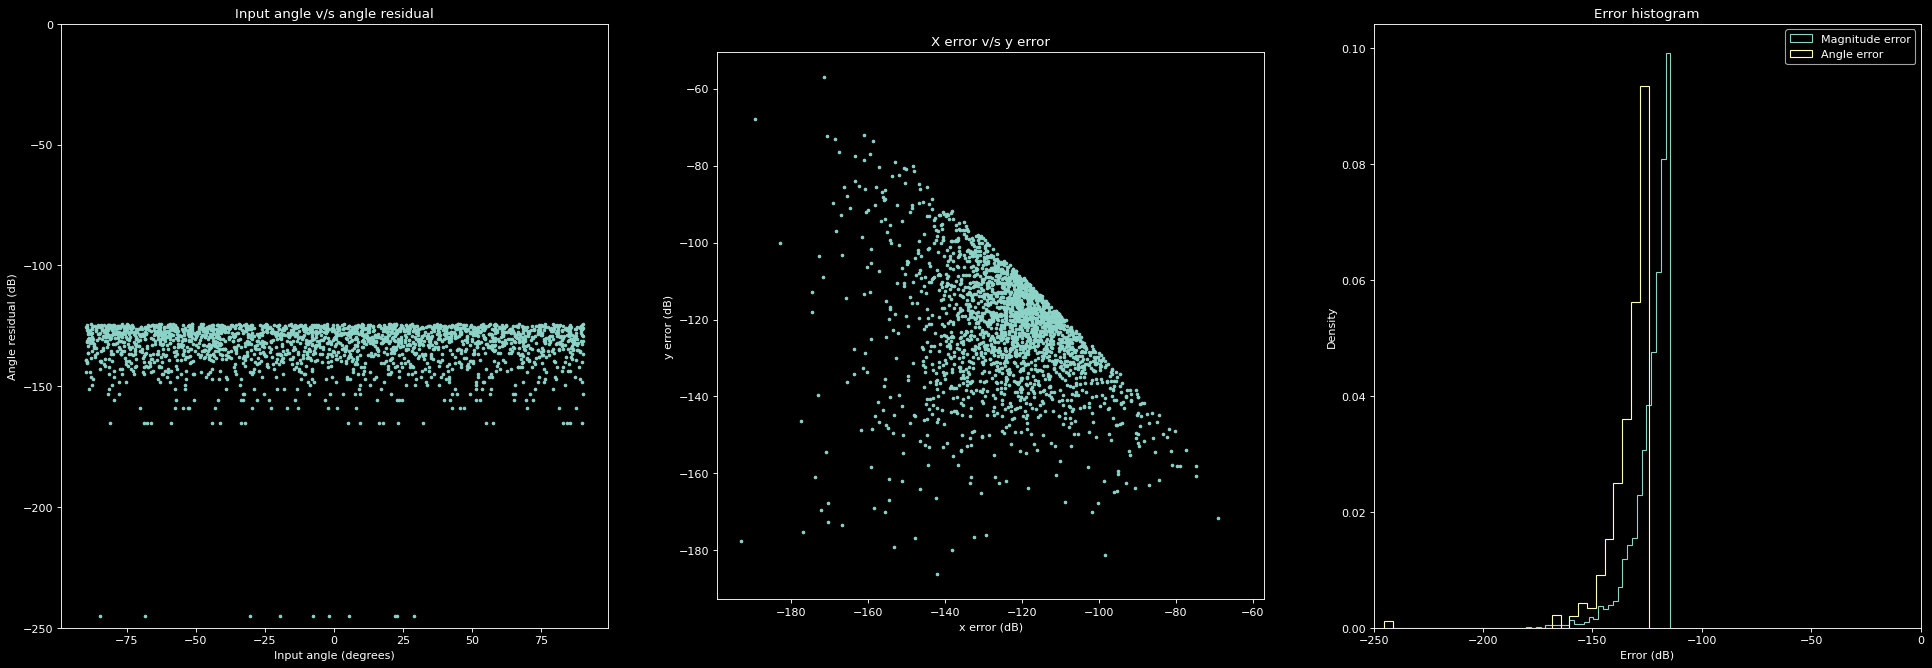

25 CORDIC iterations


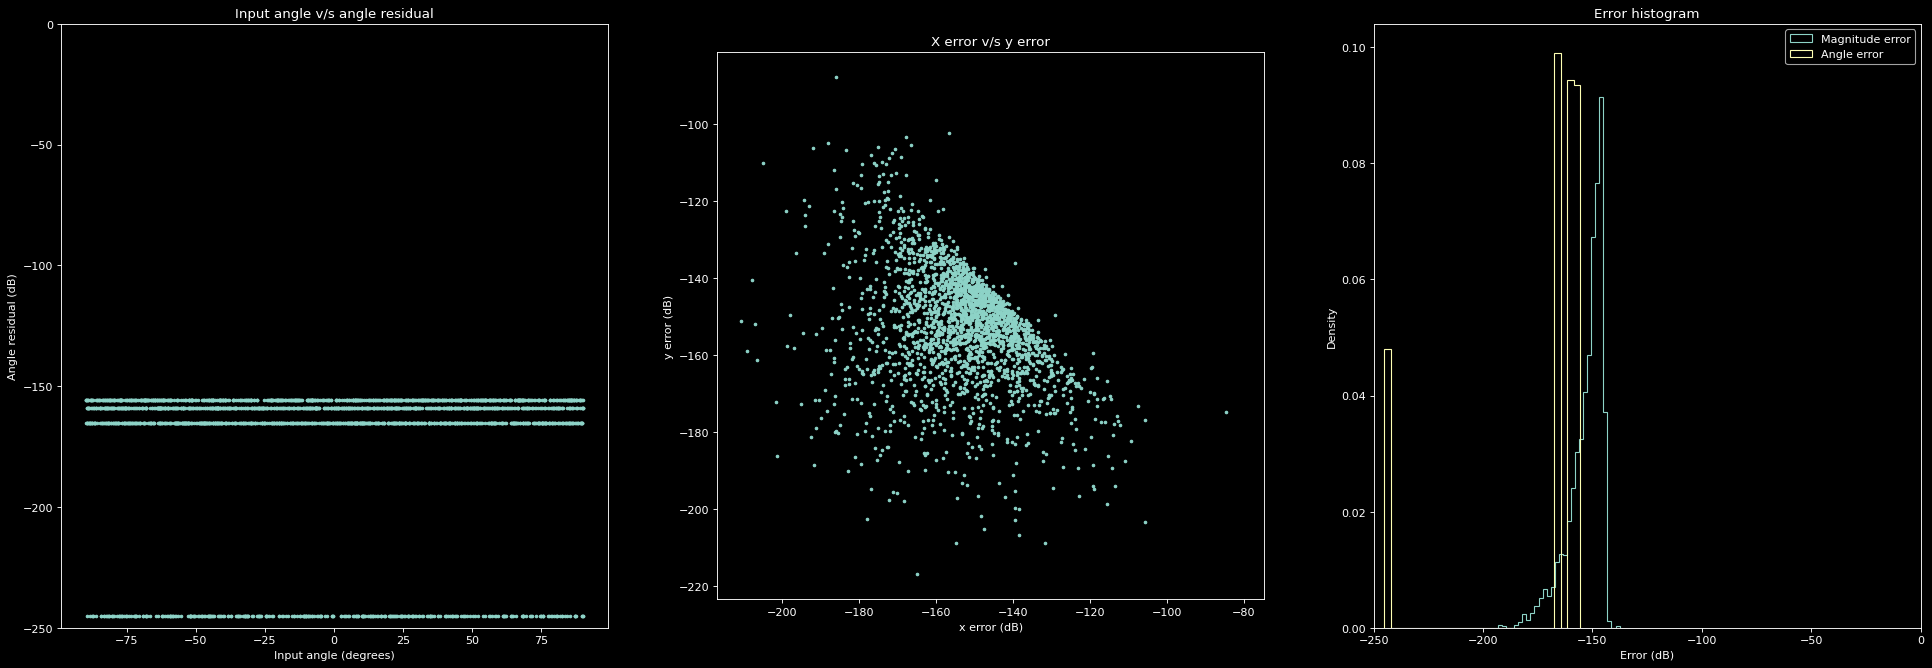

30 CORDIC iterations


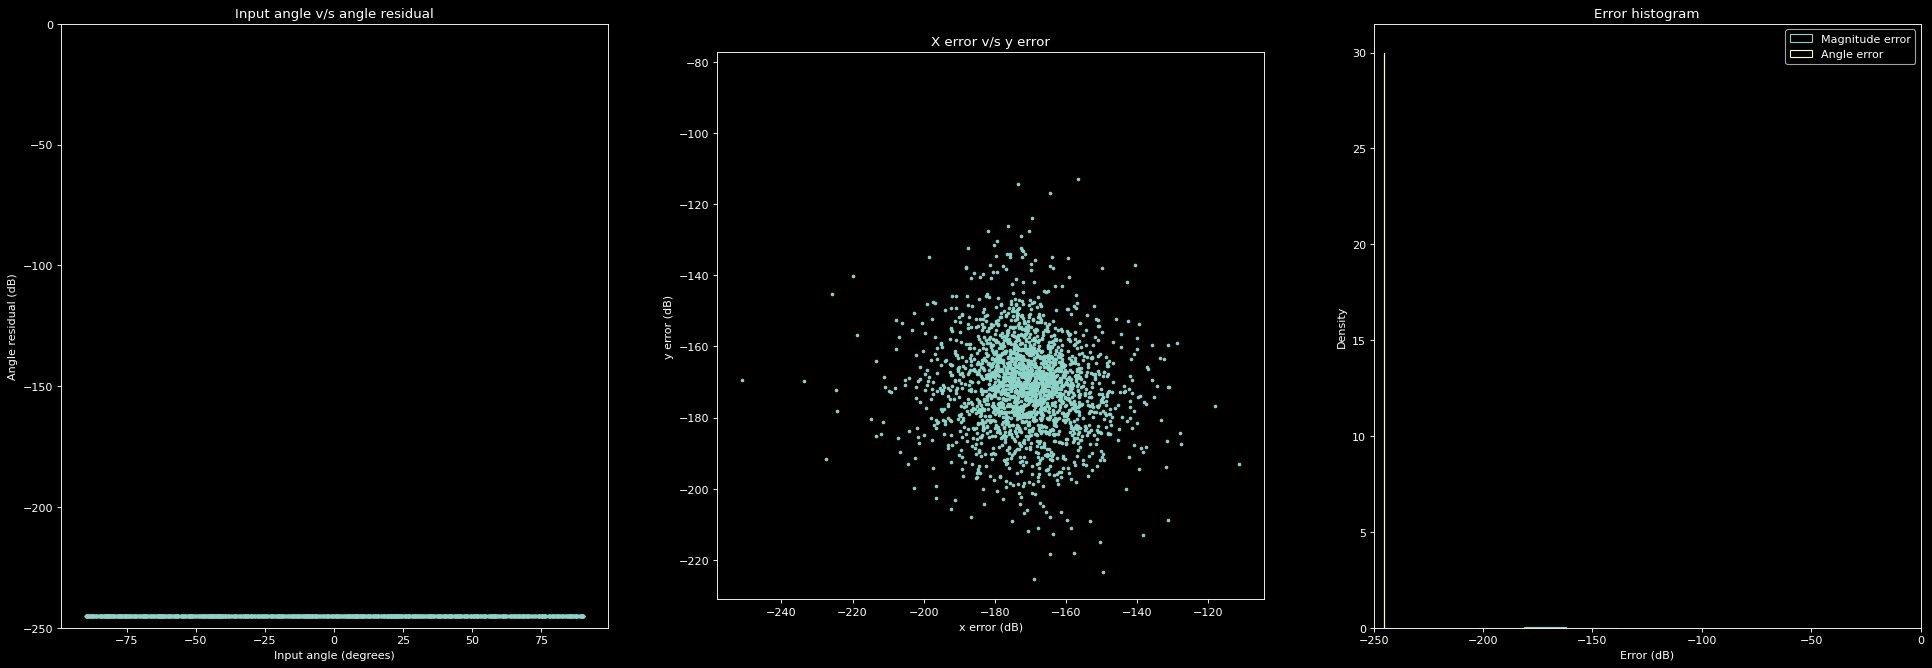

In [175]:
# Error for circular mode with different number of iterations
for i in (10, 15, 20, 25, 30):
    print("%d CORDIC iterations"%(i))
    vis_rot_error_file("data/circ_rot/cr_%d_off_off_x2500.txt"%(i))

Circular rotation without constraints


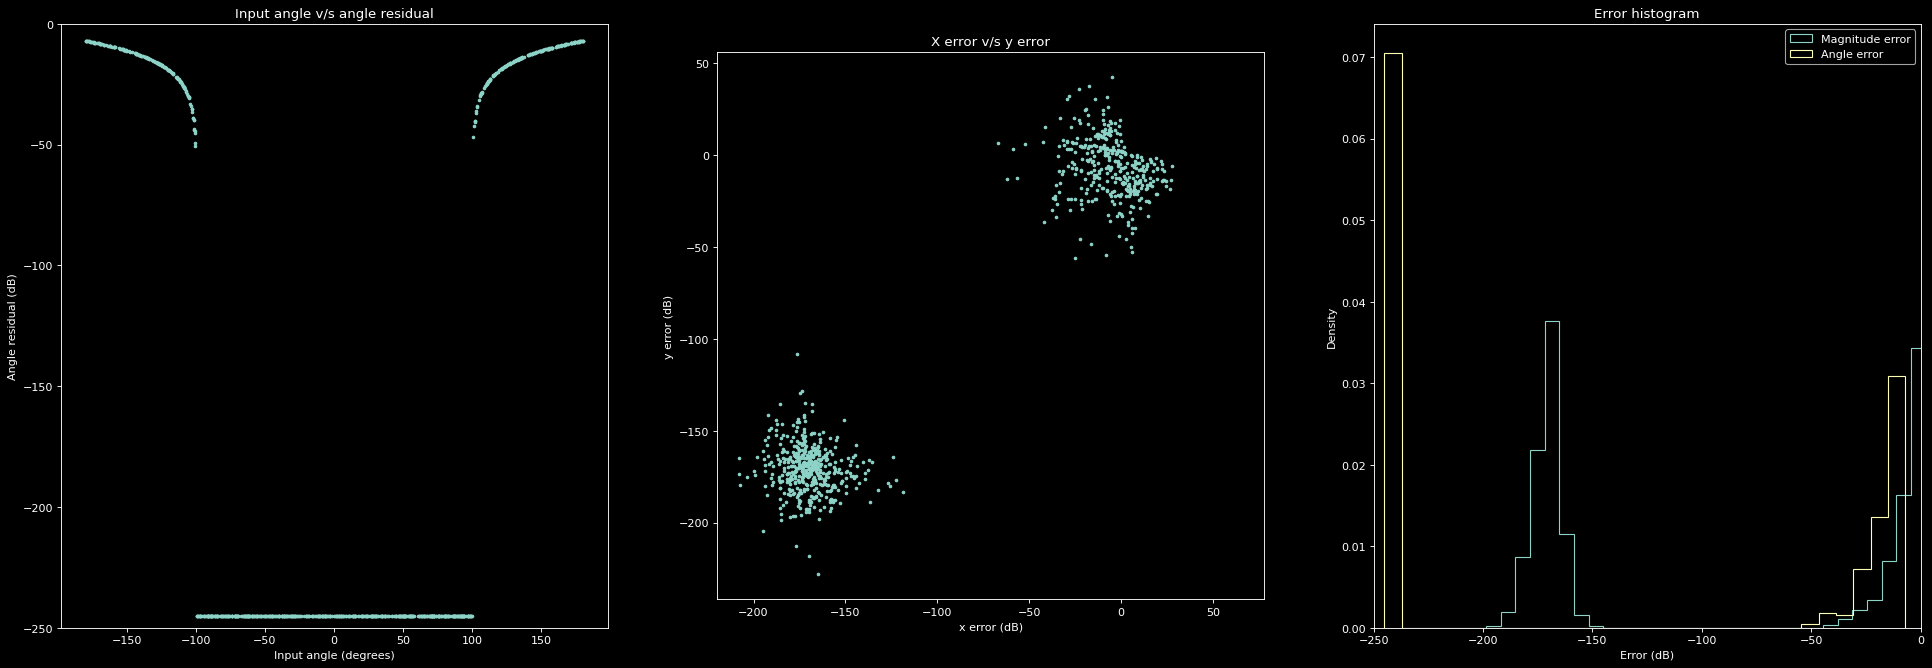

Circular rotation with constraints


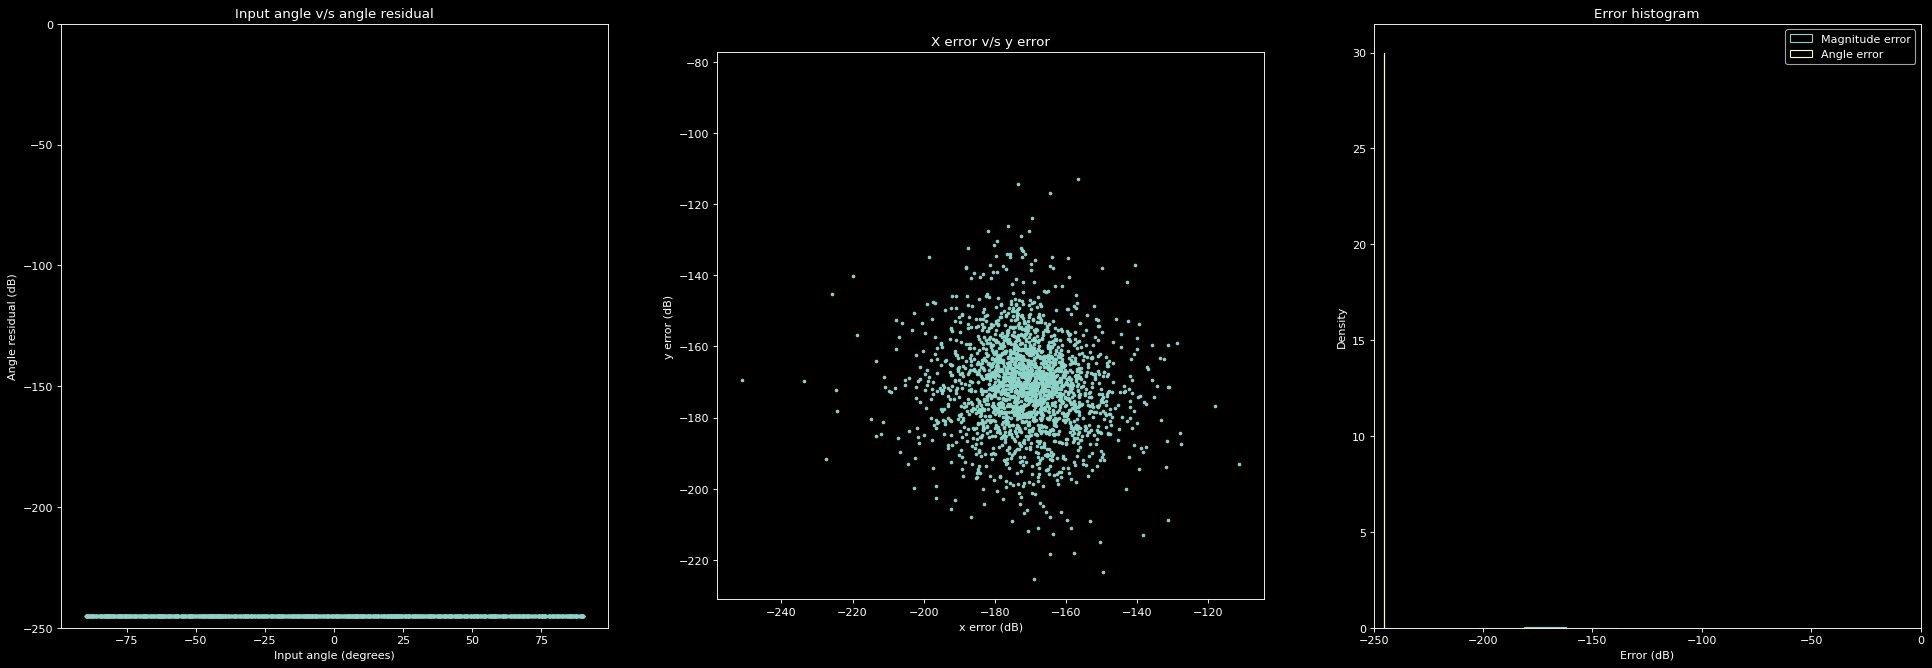

In [177]:
# View inputs for full (including inputs that will lead to out of bounds outputs)
print("Circular rotation without constraints")
vis_rot_error_file("data/circ_rot/cr_30_off_off_x2500_full.txt")

print("Circular rotation with constraints")
vis_rot_error_file("data/circ_rot/cr_30_off_off_x2500.txt")

---

## Hyperbolic mode error analysis

Look at the following to see patterns in error for hyperbolic rotation mode for different number of CORDIC iterations and also compare the error plot when we do not apply the given constraints on angle, input values, etc

10 CORDIC iterations


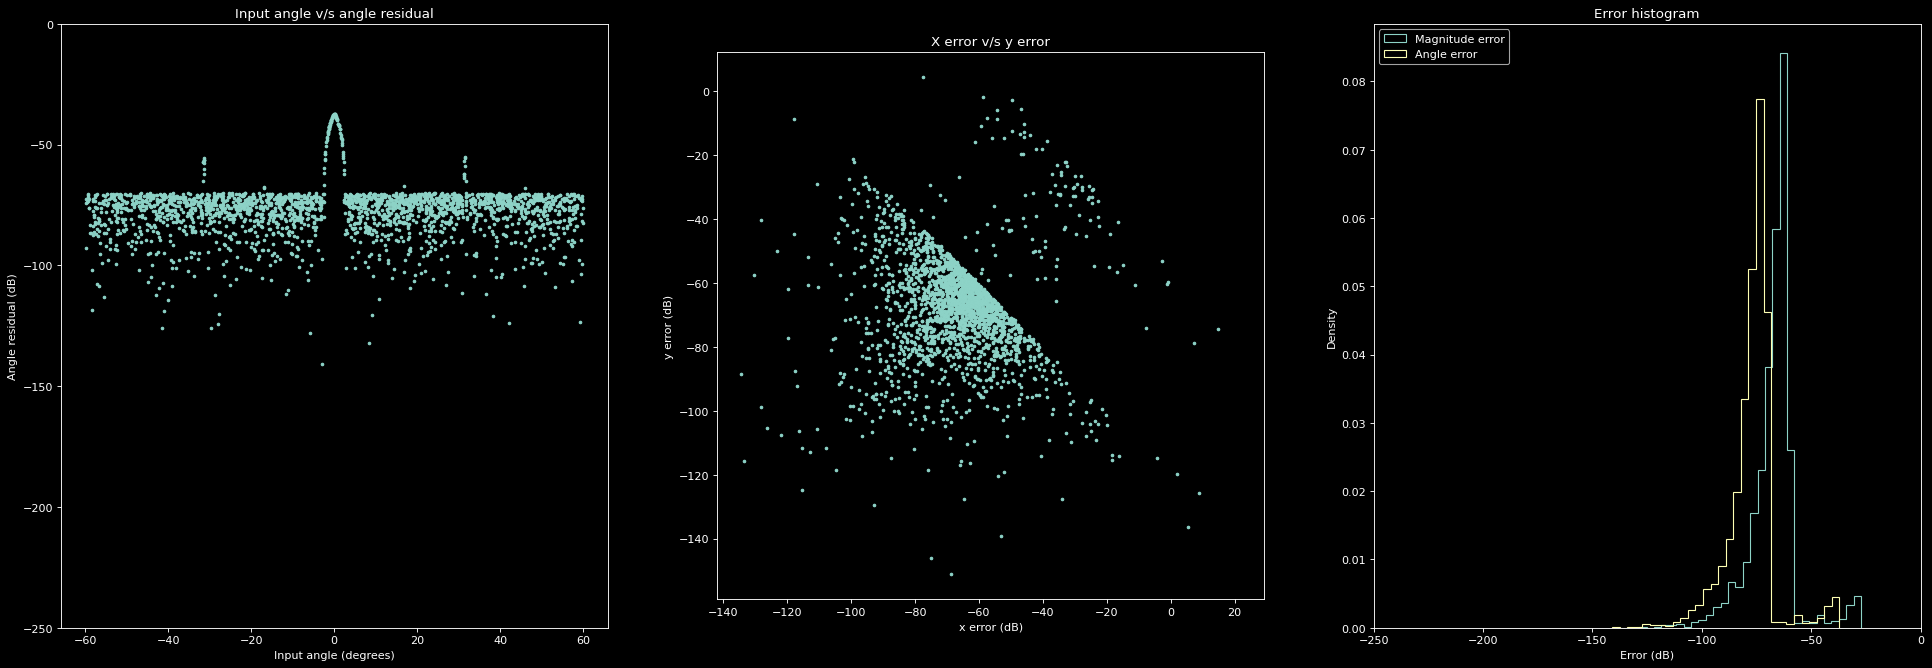

15 CORDIC iterations


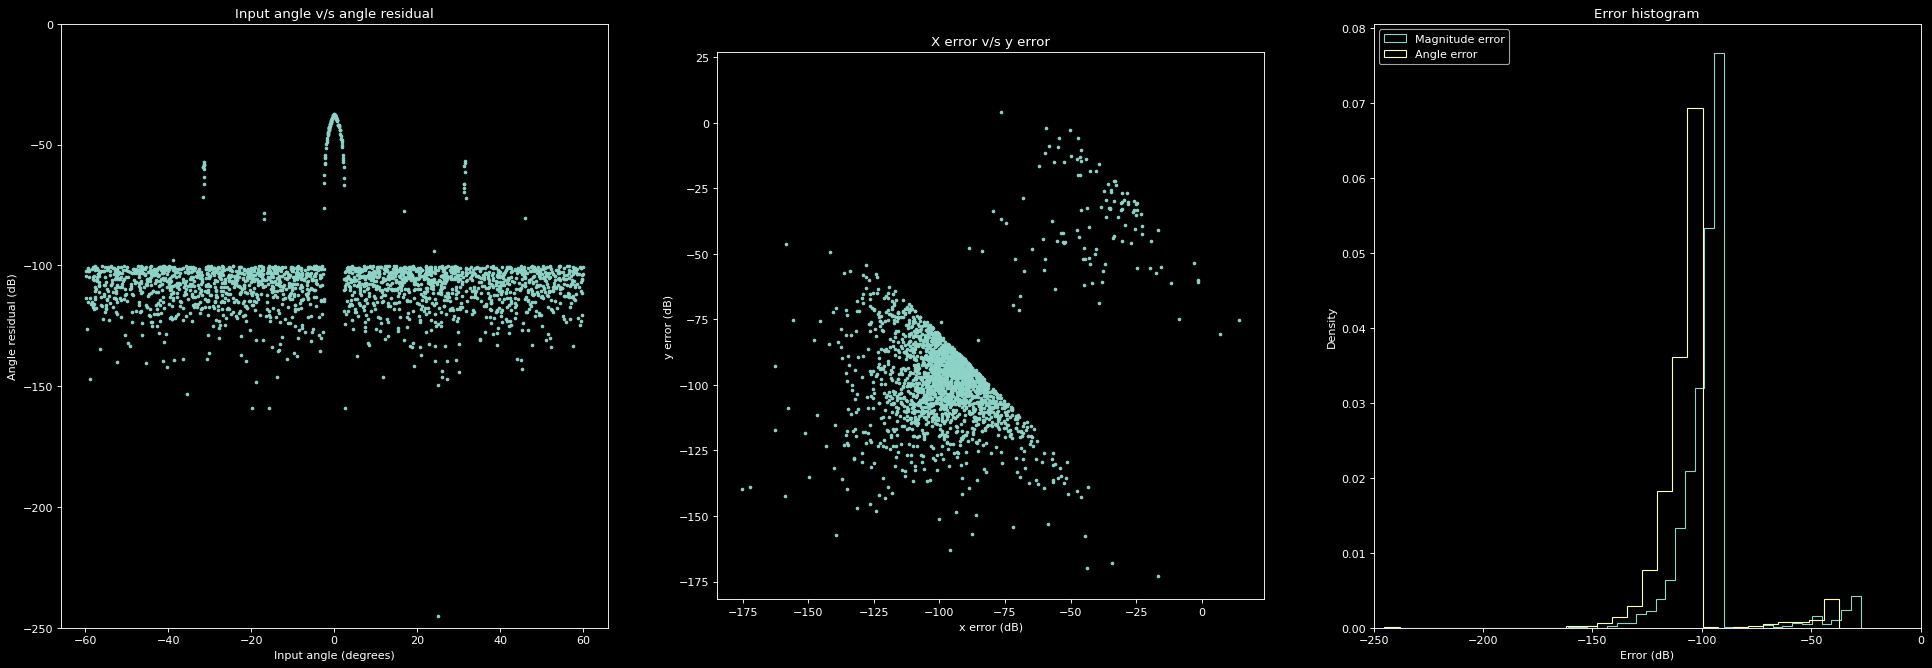

20 CORDIC iterations


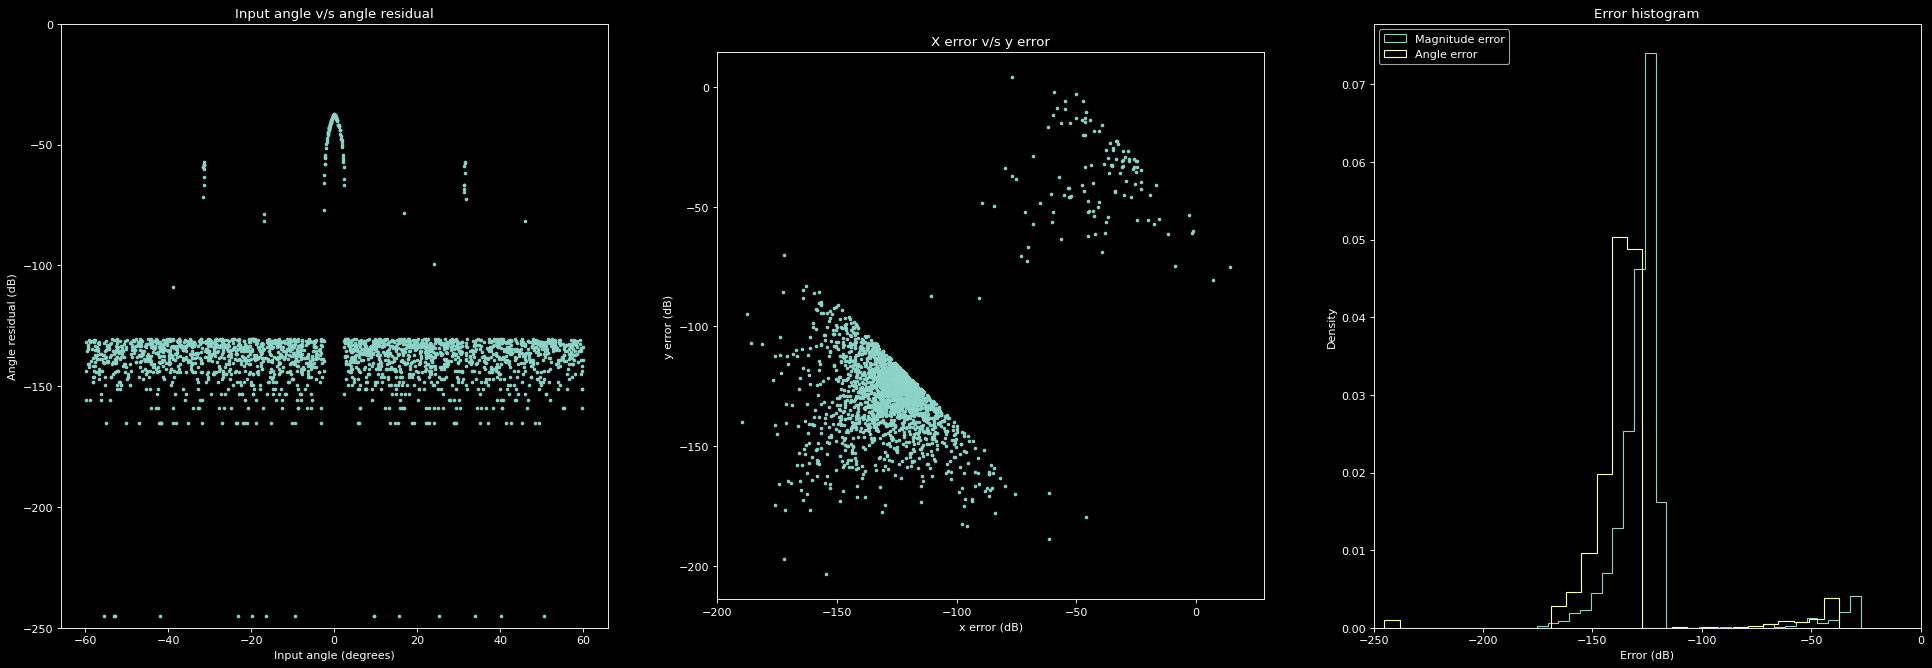

25 CORDIC iterations


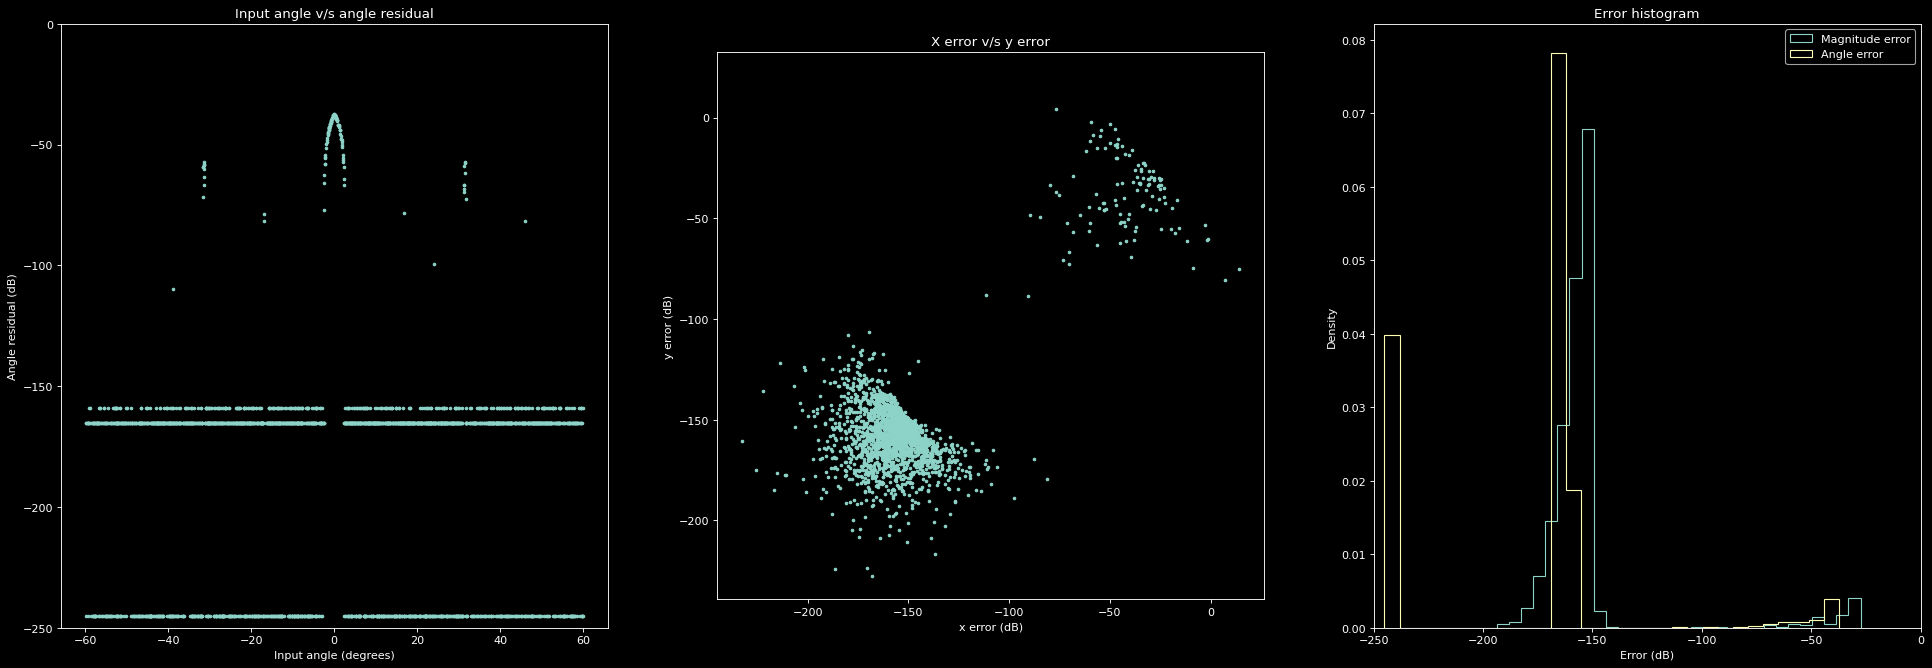

30 CORDIC iterations


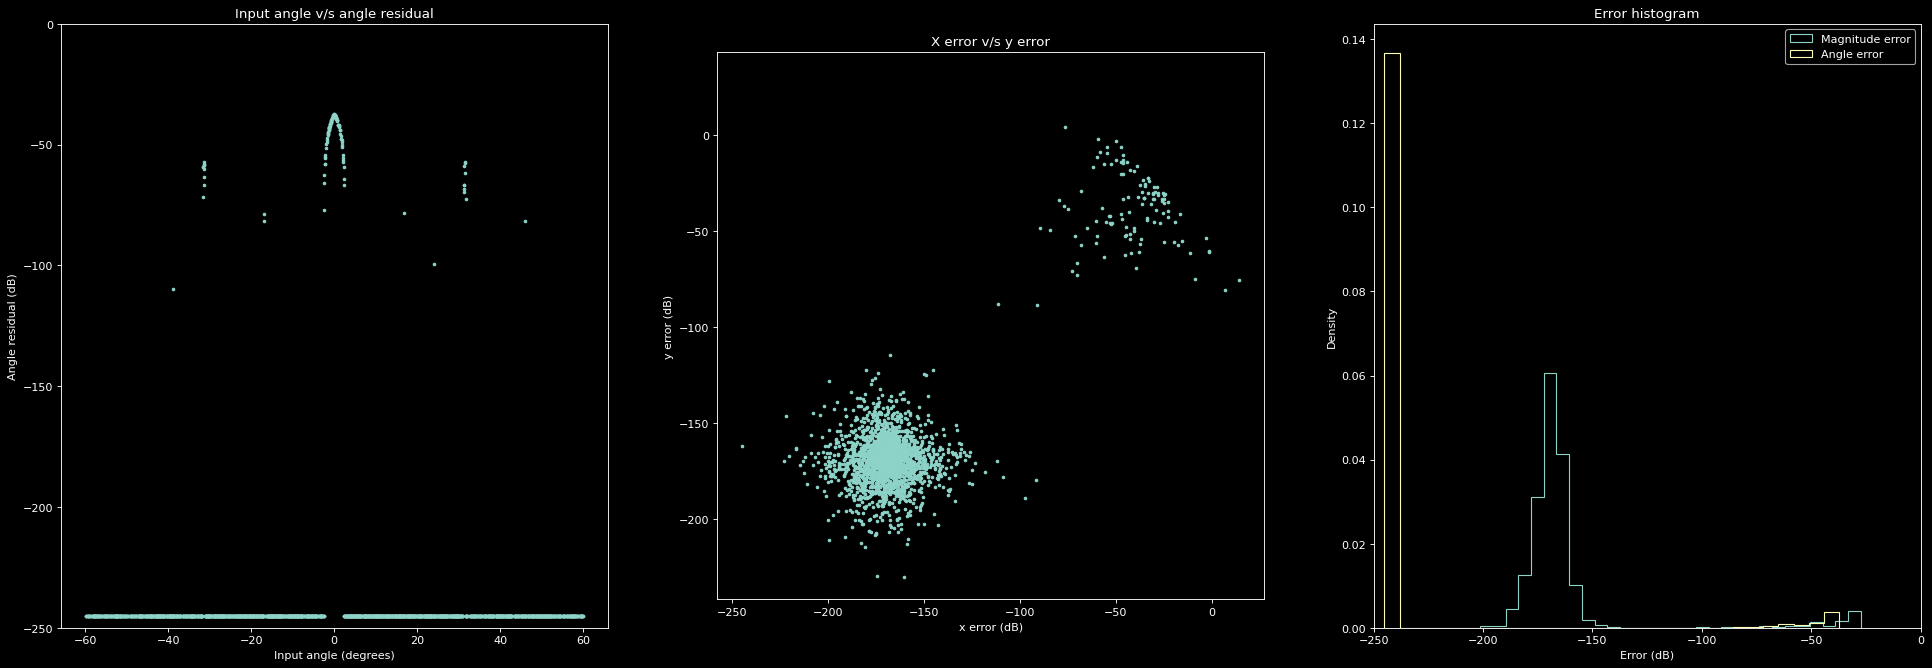

In [178]:
# Error for hyperbolic mode with different number of iterations
for i in (10, 15, 20, 25, 30):
    print("%d CORDIC iterations"%(i))
    vis_rot_error_file("data/hyp_rot/hr_%d_off_off_x2500.txt"%(i))

Hyperbolic rotation without constraints


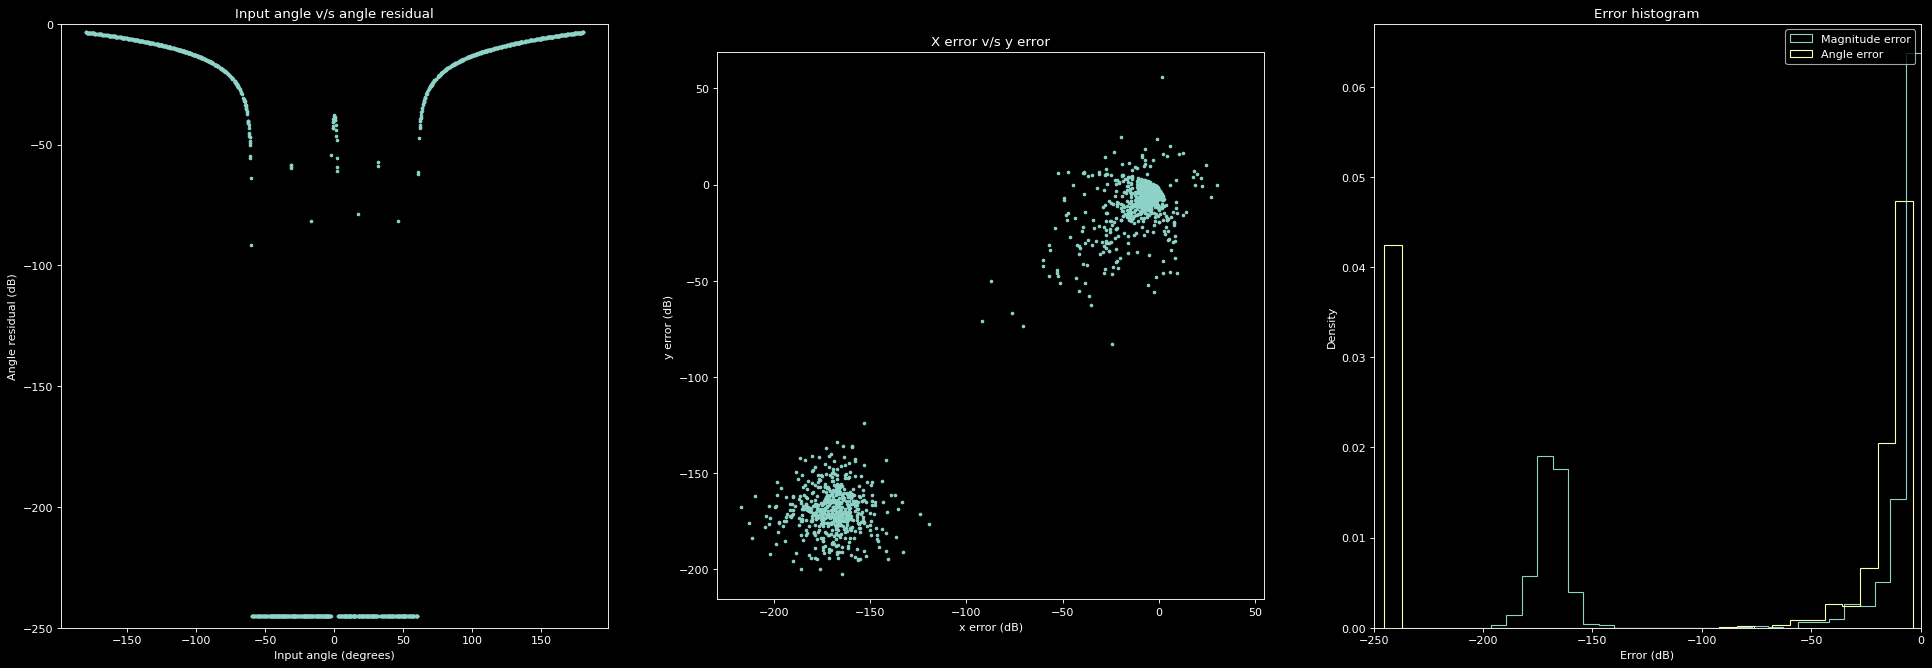

Hyperbolic rotation with constraints


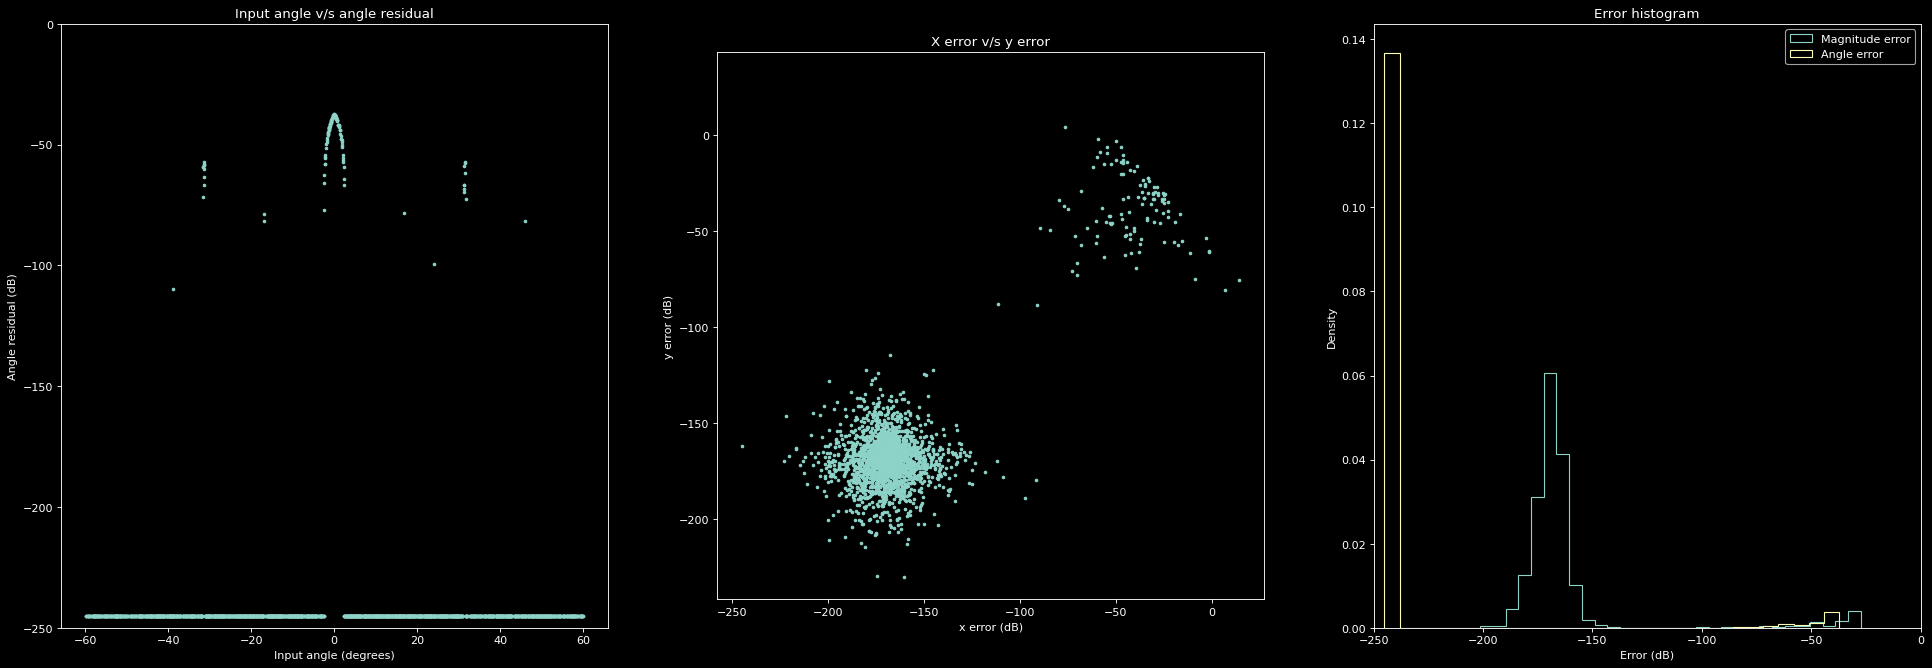

In [179]:
# View inputs for full (including inputs that will lead to out of bounds outputs)
print("Hyperbolic rotation without constraints")
vis_rot_error_file("data/hyp_rot/hr_30_off_off_x2500_full.txt")

print("Hyperbolic rotation with constraints")
vis_rot_error_file("data/hyp_rot/hr_30_off_off_x2500.txt")